In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


### Loading data

In [2]:
train_data = pd.read_csv("./data/train.csv", index_col="PassengerId")
test_data = pd.read_csv("./data/test.csv", index_col="PassengerId")
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Survival: if the passenger has survived | 0 = No, 1 = Yes
- Pclass: Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex: Sex
- Age: Age in years
- SibSp: # of siblings / spouses aboard the Titanic
- Parch: # of parents / children aboard the Titanic
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

#### Column "Carbin" has a lot of null data, so we'll ignore this column

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
train_data.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C
654,1,3,"O'Leary, Miss. Hanora ""Norah""",female,NaN,0,0,330919,7.8292,NaN,Q
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S
703,0,3,"Barbara, Miss. Saiide",female,18.0,0,1,2691,14.4542,NaN,C
850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,349912,7.7750,NaN,S
792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S


In [5]:
[print(column, ": ", train_data[column].nunique()) for column in train_data.columns]

Survived :  2
Pclass :  3
Name :  891
Sex :  2
Age :  88
SibSp :  7
Parch :  7
Ticket :  681
Fare :  248
Cabin :  147
Embarked :  3


[None, None, None, None, None, None, None, None, None, None, None]

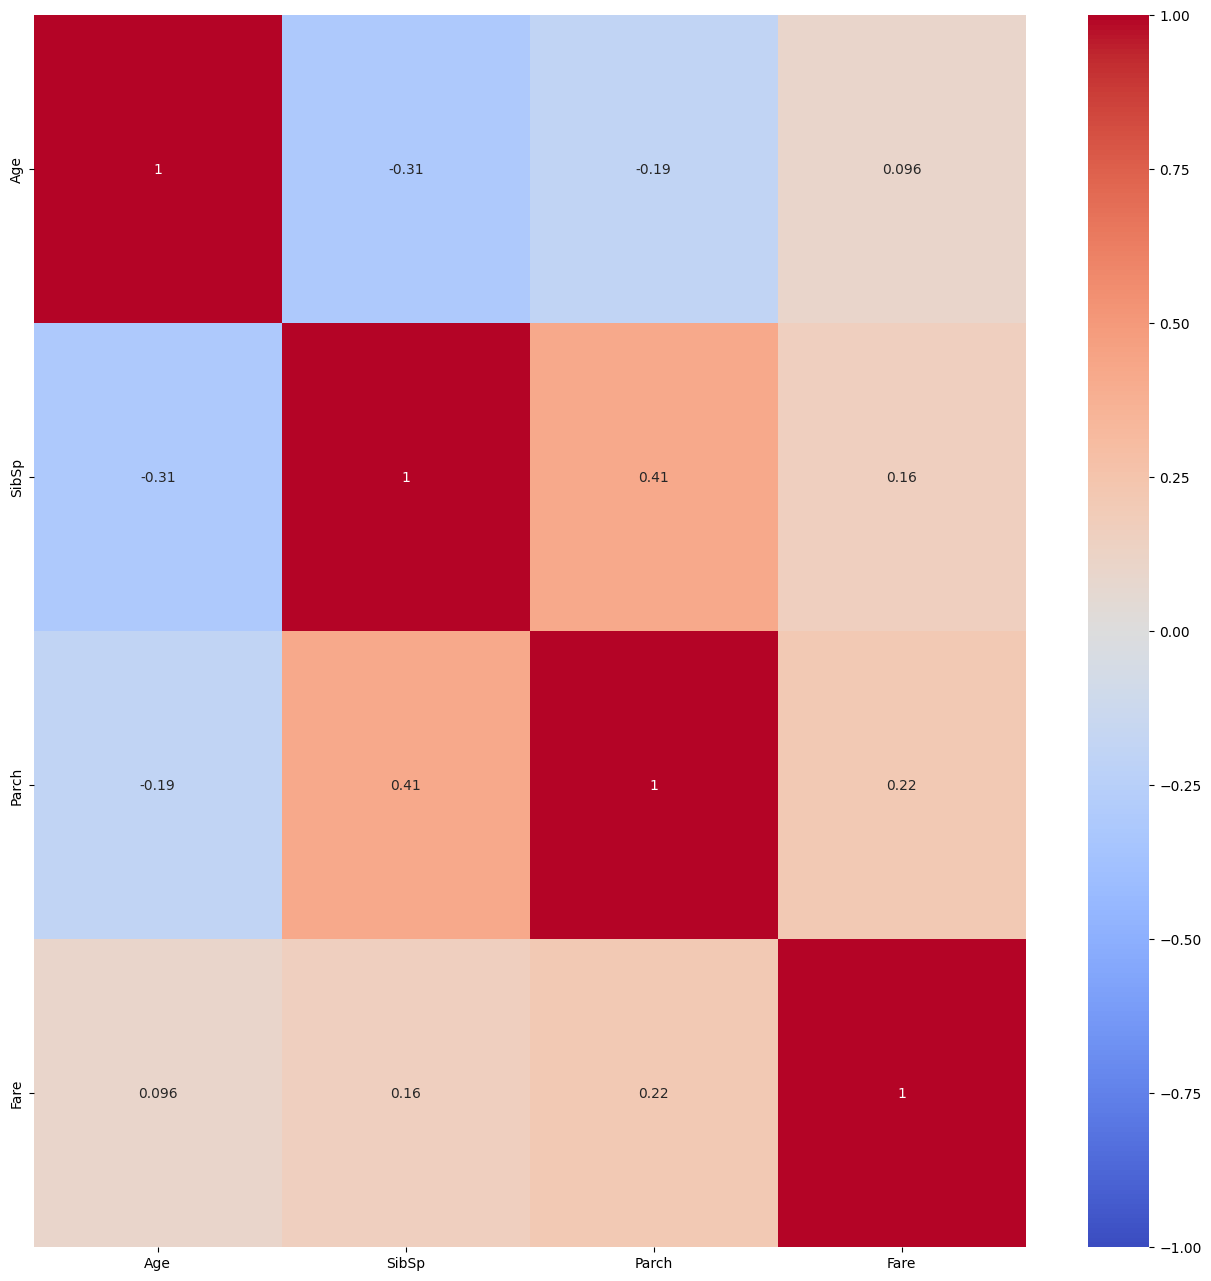

In [119]:
numerical_cols = ["Age", "SibSp", "Parch", "Fare"]

corr= train_data[numerical_cols].corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### Split data in train and validation

In [6]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X = train_data[features]
y = train_data.Survived

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                      test_size=0.2, random_state=0)
X_test = test_data[features]

### Define scores for the encoders

In [7]:
def score_dataset_random_forest(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def score_dataset_XGBoost(X_train, X_valid, y_train, y_valid):
    model = XGBClassifier(n_estimators=500, learning_rate=0.05, n_jobs=4,
                          early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              verbose=False)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [9]:
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

### Evaluating better strategies to Imputation

In [10]:
strategies = ["mean", "median", "most_frequent", "constant"]

In [19]:
def score_imputer_strategy(strategy):
      imputer = SimpleImputer(strategy=strategy)
      imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
      imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))
      imputed_X_train.columns = X_train.columns
      imputed_X_valid.columns = X_valid.columns

      random_forest_score = score_dataset_random_forest(imputed_X_train, imputed_X_valid,
                                                        y_train, y_valid)
      xgboost_score = score_dataset_XGBoost(imputed_X_train, imputed_X_valid,
                                            y_train, y_valid)

      return random_forest_score, xgboost_score

def score_imputer_plus_strategy(strategy):
      X_train_plus = X_train.copy()
      X_valid_plus = X_valid.copy()

      cols_with_missing = ["Age"]

      for col in cols_with_missing:
            X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
            X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

      imputer = SimpleImputer(strategy=strategy)
      imputed_X_train_plus = pd.DataFrame(imputer.fit_transform(X_train_plus))
      imputed_X_valid_plus = pd.DataFrame(imputer.transform(X_valid_plus))

      imputed_X_train_plus.columns = X_train_plus.columns
      imputed_X_valid_plus.columns = X_valid_plus.columns

      random_forest_score = score_dataset_random_forest(imputed_X_train_plus,
                                                        imputed_X_valid_plus,
                                                        y_train, y_valid)
      xgboost_score = score_dataset_XGBoost(imputed_X_train_plus, imputed_X_valid_plus,
                                            y_train, y_valid)

      return random_forest_score, xgboost_score

def score_without_imputer():
      X_train_none = X_train.copy()
      X_valid_none = X_valid.copy()

      X_train_none.fillna(0, inplace=True)
      X_valid_none.fillna(0, inplace=True)

      random_forest_score = score_dataset_random_forest(X_train_none, X_valid_none, 
                                                        y_train, y_valid)
      xgboost_score = score_dataset_XGBoost(X_train_none, X_valid_none, y_train,
                                            y_valid)

      return random_forest_score, xgboost_score

# print("MAE from Approach Imputation:")
# print("MAE from Approach An Extension to Imputation:")


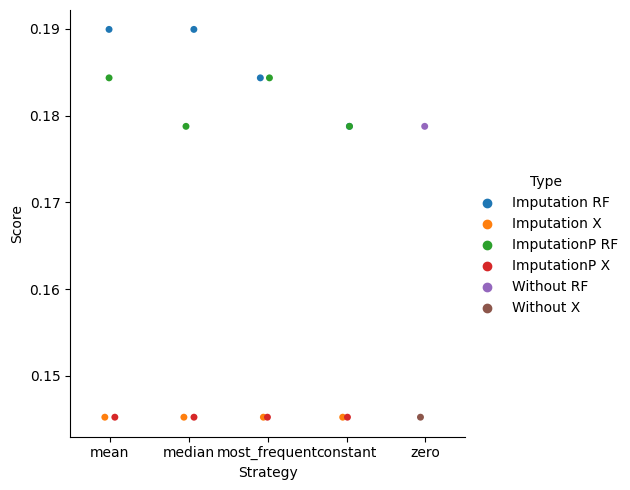

In [21]:
scores_to_imputation_random_forest = []
scores_to_imputation_plus_random_forest = []
scores_to_imputation_xgboost = []
scores_to_imputation_plus_xgboost = []

for strategy in strategies:
    imputation_random_forest_score, imputation_xgboost_score = score_imputer_strategy(strategy)
    imputation_plus_random_forest_score, imputation_plus_xgboost_score = score_imputer_plus_strategy(strategy)

    scores_to_imputation_random_forest.append(imputation_random_forest_score)
    scores_to_imputation_xgboost.append(imputation_xgboost_score)
    scores_to_imputation_plus_random_forest.append(imputation_plus_random_forest_score)
    scores_to_imputation_plus_xgboost.append(imputation_plus_xgboost_score)

without_random_forest_score, without_xgboost_score = score_without_imputer()

types_name = ["Imputation RF"] * 4 + ["Imputation X"] * 4 + ["ImputationP RF"] * 4 + ["ImputationP X"] * 4 + ["Without RF"] + ["Without X"]
strategies_names = [] 
for _ in range(len(strategies)):
    strategies_names += strategies
strategies_names += ["zero"] * 2

scores = scores_to_imputation_random_forest + scores_to_imputation_xgboost + scores_to_imputation_plus_random_forest + scores_to_imputation_plus_xgboost + [without_random_forest_score, without_xgboost_score]

scores_dataset = pd.DataFrame({"Strategy": strategies_names, "Score": scores, "Type": types_name})

sns.catplot(x="Strategy", y="Score", hue="Type", data=scores_dataset)

In [31]:
scores_dataset.groupby("Type").apply(lambda df: df.loc[df.Score.idxmin()])

,Strategy,Score,Type
Type,,,
Imputation RF,constant,0.178771,Imputation RF
Imputation X,mean,0.145251,Imputation X
ImputationP RF,median,0.178771,ImputationP RF
ImputationP X,mean,0.145251,ImputationP X
Without RF,zero,0.178771,Without RF
Without X,zero,0.145251,Without X


- To XGBoost has a better performance independent to the strategy
- RandomForest performed better in median for Imputation Plus and constant for both imputation
- To simply, we'll choose to Simple Imputer

### Tuning Models

In [ ]:
imputer = SimpleImputer(strategy="constant")
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#### RandomForest

In [45]:
# params_grid_rf = {
#     'max_depth': [1, 3, 5, 7, 10],
#     'n_estimators': [100, 150, 200, 250, 300, 350, 400],
#     'max_leaf_nodes': [10, 25, 50, 75, 100],
#     'criterion': ["gini", "entropy", "log_loss"],
# }
# rf_model = RandomForestClassifier()

# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=params_grid_rf, cv=cv_strat,
#                            n_jobs=-1, verbose=1)
# grid_search_rf.fit(imputed_X_train, y_train)

# print(grid_search_rf.best_params_)

Fitting 5 folds for each of 525 candidates, totalling 2625 fits
{'criterion': 'log_loss', 'max_depth': 10, 'max_leaf_nodes': 50, 'n_estimators': 100}


#### XGBoost

In [41]:
# params_grid_xgb = {
#     'learning_rate': [0.01, 0.02, 0.05, 0.10],
#     'max_depth': [1, 3, 5, 7],
#     'n_estimators': [100, 150, 200, 250, 300, 350, 400],
#     'early_stopping_rounds': [10, 15, 20]
# }
# xgb_model = XGBClassifier()

# grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=params_grid_xgb,
#                                cv=cv_strat, n_jobs=-1, verbose=1)
# grid_search_xgb.fit(imputed_X_train, y_train, eval_set=[(imputed_X_valid, y_valid)],
#                 verbose=False)

# print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


Creating pipelines

In [110]:
numerical_cols = ["Age", "SibSp", "Parch", "Fare"]

final_model_random_forest = RandomForestClassifier(n_estimators=100, criterion="log_loss",
                                                   max_leaf_nodes=50,  max_depth=10,
                                                   random_state=0)
final_model_XGBoost = XGBClassifier(n_estimators=100, learning_rate=0.1, n_jobs=4,
                                   early_stopping_rounds=10, colsample_bytree=0.6,
                                   max_depth=7, min_child_weight=7, reg_alpha=0,
                                   random_state=0)

X = train_data[features]
y = train_data.Survived
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                      test_size=0.2, random_state=0)
X_test = test_data[features]

X_columns = X.columns
X_train_columns = X_train.columns
X_valid_columns = X_valid.columns
X_test_columns = X_test.columns

imputer = SimpleImputer(strategy="most_frequent")
X = pd.DataFrame(imputer.fit_transform(X))
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_valid = pd.DataFrame(imputer.transform(X_valid))
X_test = pd.DataFrame(imputer.transform(X_test))
X.columns = X_columns
X_train.columns = X_train_columns
X_valid.columns = X_valid_columns
X_test.columns = X_test_columns
X[numerical_cols] = X[numerical_cols].apply(pd.to_numeric)
X_train[numerical_cols] = X_train[numerical_cols].apply(pd.to_numeric)
X_valid[numerical_cols] = X_valid[numerical_cols].apply(pd.to_numeric)
X_test[numerical_cols] = X_test[numerical_cols].apply(pd.to_numeric)


X = pd.get_dummies(X)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

final_model_random_forest.fit(X, y)
final_model_XGBoost.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

predictions_random_forest = final_model_random_forest.predict(X_test)
predictions_xgboost = final_model_XGBoost.predict(X_test)


In [120]:
output_random_forest = pd.DataFrame({'PassengerId': test_data.index,
                                     'Survived': predictions_random_forest})
output_random_forest.to_csv('results/submission_random_forest.csv', index=False)

output_xgboost = pd.DataFrame({'PassengerId': test_data.index,
                               'Survived': predictions_xgboost})
output_xgboost.to_csv('results/submission_xgboost.csv', index=False)
print("Your submissions were successfully saved!")

Your submissions were successfully saved!
